<a href="https://colab.research.google.com/github/nguyenvuong1309/Do-an-lap-trinh-an-toan/blob/main/BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import pandas as pd
from numpy import zeros, newaxis
import numpy as np
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional,Activation
import csv


In [30]:
csv_file_path = '/content/drive/MyDrive/Colab/dataset/text_dataset.csv'
df = pd.read_csv(csv_file_path,sep=",")

In [31]:
dataset = df

In [32]:
print(dataset.head())

   Index                                                  1  label
0      0  1 150200/dirent_uri.c memset 405\nconst char *...      0
1      1  2 79848/CWE134_Uncontrolled_Format_String__cha...      0
2      2  3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...      0
3      3  4 151133/utils.c strcmp 737\nint avformat_open...      0
4      4  5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...     32


In [33]:
dataset = dataset[['1','label']]
dataset.head()

,1,label
0,1 150200/dirent_uri.c memset 405\nconst char *...,0
1,2 79848/CWE134_Uncontrolled_Format_String__cha...,0
2,3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...,0
3,4 151133/utils.c strcmp 737\nint avformat_open...,0
4,5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...,32


In [34]:
print(dataset['label'].unique())
print(len(dataset['label'].unique()))

[ 0 32  4 10 20 36  3  1 12 25 15 34 16 11  2 14 35 38  9 29  7 18 37 21
 22 23  5  8 17 31 39 33 28 30 19 40 26 13 24 27  6]
41


In [35]:
train_dataset = dataset[0:int(len(dataset) * 0.8)]
test_dataset =  dataset[int(len(dataset) * 0.8) :]

In [36]:
#<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>
text_data = train_dataset['1'].values
tensor = tf.data.Dataset.from_tensor_slices(text_data)

In [37]:
tensor

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [38]:
train_dataset_numpy = np.array(train_dataset)

In [39]:
print(train_dataset_numpy[:3])

[['1 150200/dirent_uri.c memset 405\nconst char *svn_relpath__internal_style(const char *relpath,apr_pool_t *pool) 861\nreturn svn_relpath_canonicalize ( internal_style ( relpath , pool ) , pool ) ; 863\nconst char *svn_relpath_canonicalize(const char *relpath,apr_pool_t *pool) 1411\nreturn canonicalize ( type_relpath , relpath , pool ) ; 1413\nstatic const char *canonicalize(path_type_t type,const char *path,apr_pool_t *pool) 389\nchar * canon ; 391\nchar * dst ; 392\nif ( path [ 0 ] == \'\\0\' )  401\ndst = canon = ( memset ( apr_palloc ( pool , strlen ( path ) + 1 ) , 0 , strlen ( path ) + 1 ) ); 405\nwhile ( ( * src ) != \':\' )  419\n* ( dst ++ ) = canonicalize_to_lower ( * ( src ++ ) ); 420\n* ( dst ++ ) = \':\'; 423\n* ( dst ++ ) = 47; 424\n* ( dst ++ ) = 47; 425\nsrc += 3; 426\nseg = src; 429\nwhile ( * src && ( * src ) != 47 && ( * src ) != 64 )  430\nsrc ++; 431\nif ( ( * src ) == 64 )  432\nseglen = ( src - seg + 1 ); 434\nmemcpy ( dst , seg , seglen ); 435\ndst += seglen; 4

In [40]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [41]:
train_dataset = train_dataset.sample(frac=0.5, replace=True, random_state=1)
test_dataset = test_dataset.sample(frac=0.5, replace=True, random_state=1)

In [42]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tensor)

In [43]:
train_dataset['1']

128037    128038 65080/CWE121_Stack_Based_Buffer_Overflo...
5192      5193 80996/CWE134_Uncontrolled_Format_String__...
50057     50058 63206/CWE121_Stack_Based_Buffer_Overflow...
109259    109260 152935/config_file.c strlen 925\ninline...
73349     73350 117223/CWE789_Uncontrolled_Mem_Alloc__ma...
                                ...                        
85221     85222 93409/CWE256_Plaintext_Storage_of_Passwo...
17921     17922 99720/CWE401_Memory_Leak__malloc_realloc...
113980    113981 149951/color.c strlen 402\nvoid parse_d...
117534    117535 117207/CWE789_Uncontrolled_Mem_Alloc__m...
40580     40581 72811/CWE122_Heap_Based_Buffer_Overflow_...
Name: 1, Length: 72000, dtype: object

In [44]:
train_dataset

,1,label
128037,128038 65080/CWE121_Stack_Based_Buffer_Overflo...,0
5192,5193 80996/CWE134_Uncontrolled_Format_String__...,0
50057,50058 63206/CWE121_Stack_Based_Buffer_Overflow...,0
109259,109260 152935/config_file.c strlen 925\ninline...,22
73349,73350 117223/CWE789_Uncontrolled_Mem_Alloc__ma...,0
...,...,...
85221,85222 93409/CWE256_Plaintext_Storage_of_Passwo...,0
17921,17922 99720/CWE401_Memory_Leak__malloc_realloc...,0
113980,113981 149951/color.c strlen 402\nvoid parse_d...,0
117534,117535 117207/CWE789_Uncontrolled_Mem_Alloc__m...,0


In [45]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '0', 'if', 'data', '1', 'char', 'void', 'i', 'd', 's',
       'service', 'sizeof', 'int', '100', 'recvresult', '2', 'static',
       'datalen', 'null'], dtype='<U559')

In [46]:
example = [[' /CWE_Heap_Based_Buffer_Overflow__cpp_CWE_char_snprintf_.cpp memset \nvoid bad() \nchar * data ; \ndata = new char [  ]; \nif ( GLOBAL_CONST_TRUE )  \nmemset ( data , \'A\' ,  -  ); \ndata [  -  ] = \'\\\'; \nSNPRINTF ( dest , strlen ( data ) , "%s" , data ); \nprintLine ( data ); \nvoid printLine (const char * line) \nif ( line != NULL )  \nprintf ( "%s\\n" , line ); \ndelete [ ] data \n\n'],
 [' /CWE_Trapdoor__ip_based_logic_.c send \nvoid CWE_Trapdoor__ip_based_logic__bad() \nWSADATA wsaData ; \nstruct sockaddr_in service , acceptService ; \nif ( WSAStartup ( MAKEWORD (  ,  ) , & wsaData ) != NO_ERROR )  \nlistenSocket = socket ( AF_INET , SOCK_STREAM , IPPROTO_TCP ); \nif ( listenSocket == INVALID_SOCKET )  \nmemset ( & service ,  , sizeof ( service ) ); \nservice . sin_family = AF_INET; \nservice . sin_addr . s_addr = INADDR_ANY; \nservice . sin_port = htons (  ); \nif ( bind ( listenSocket , ( struct sockaddr * ) & service , sizeof ( service ) ) == SOCKET_ERROR )  \nif ( listen ( listenSocket ,  ) == SOCKET_ERROR )  \nacceptSocket = accept ( listenSocket , NULL , NULL ); \nif ( acceptSocket == SOCKET_ERROR )  \nif ( getsockname ( acceptSocket , ( struct sockaddr * ) & acceptService , & acceptServiceLen ) == -  )  \nif ( strcmp ( "..." , inet_ntoa ( acceptService . sin_addr ) ) ==  )  \nif ( send ( acceptSocket , ADMIN_MESSAGE , strlen ( ADMIN_MESSAGE ) ,  ) == SOCKET_ERROR )  \nif ( send ( acceptSocket , DEFAULT_MESSAGE , strlen ( DEFAULT_MESSAGE ) ,  ) == SOCKET_ERROR )  \nwhile (  )  \n\n'],
 [' /CWE_OS_Command_Injection__char_console_wspawnl_.c strlen \nvoid CWE_OS_Command_Injection__char_console_wspawnl__bad() \nchar * data ; \nchar dataBuffer [  ] = "" ; \ndata = dataBuffer; \nif ( staticFive ==  )  \nsize_t dataLen = strlen ( data ) ; \nif (  - dataLen >  )  \nif ( fgets ( data + dataLen , ( int ) (  - dataLen ) , stdin ) != NULL )  \ndataLen = strlen ( data ); \nif ( dataLen >  && data [ dataLen -  ] == \'\\n\' )  \ndata [ dataLen -  ] = \'\\\'; \n\n']
           ]

In [47]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   1,   34,    7,  170,    6,    4,    4,  268,    6,    3,  820,
          34,    4,  111,    4,  301,   43,   29,    4,   10,    4,   54,
           4,    7,   54,   35,    6,   20,    3,   20,   19,   69,  104,
          20,  385,    4,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   1, 1532,    7,    1,   28,   28,   24,   85,   11, 5859,    3,
          88,   89,   28,   94,   32,   68,   45,   86,   95,    3,   32,
          63,   34,   11,   12,   11,   11,   91,   45,   11,   84,   83,
         184,   11,   87,   90,    3,  178,   32,   24,   80,   11,   12,
          11,   26,    3,  182,   32,   26,   47,  181,   32,   19,   19,
           3,   47,   26,    3, 7586,   47,   24,   80,

In [48]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')
])

In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [50]:
X_train = train_dataset['1']
y_train = train_dataset['label']
y_train = tf.keras.utils.to_categorical(y_train, num_classes=41)

In [51]:
print(X_train.shape)
print(y_train.shape)

(72000,)
(72000, 41)


In [25]:
history = model.fit(X_train,y_train, epochs=1,
                    # validation_data=test_dataset,
                    # validation_steps=30
                    )

2250/2250 [==============================] - 3859s 2s/step - loss: 0.6592 - accuracy: 0.8612


In [26]:
X_test = test_dataset['1']
y_test = test_dataset['label']
y_test = tf.keras.utils.to_categorical(y_test, num_classes=41)

In [27]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

563/563 [==============================] - 174s 297ms/step - loss: 0.2378 - accuracy: 0.9479
Test Loss: 0.23781825602054596
Test Accuracy: 0.9478889107704163


In [52]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred)
print(y_test.shape)
print(y_test)

563/563 [==============================] - 185s 315ms/step
(18000, 41)
[[0.0244155  0.02447476 0.0244009  ... 0.02443892 0.02444774 0.02464795]
 [0.02452617 0.02442861 0.02439974 ... 0.02431636 0.02444886 0.02446835]
 [0.02439737 0.02433275 0.02448582 ... 0.02436619 0.02439983 0.02447686]
 ...
 [0.02445894 0.02451384 0.02432592 ... 0.02457045 0.02428449 0.02453629]
 [0.02447813 0.02450938 0.02428826 ... 0.02451493 0.02433015 0.02454592]
 [0.02463439 0.02442442 0.02445234 ... 0.02446336 0.02435844 0.02449524]]
(18000, 41)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [56]:
max_y_test_indices = np.argmax(y_test, axis=1)
max_y_pred_indices = np.argmax(y_pred, axis=1)

array_sum     = [0] * 41
array_correct = [0] * 41

array_sum = np.array(array_sum)
array_correct = np.array(array_correct)



for i in range(len(max_y_test_indices)):
  if max_y_test_indices[i] == max_y_pred_indices[i]:
    array_correct[max_y_test_indices[i]] += 1
  array_sum[max_y_test_indices[i]] += 1

print(array_sum)
print(len(array_sum))
print(array_correct)
print(len(array_correct))


[13755   145   145  1885   341    17     1     2    14    30   206    17
   100     0    58   407    13    17    37     1   500     6     6    12
     2    23     4     3     5    41     1     8    63    17    42    25
    36     3     1    11     0]
41
[356   1   0   4   0   0   0   0   0   0   0   0   0   0   0  16   0   0
   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
   0   0   0   0   0]
41


<ipython-input-66-4f599df2b44e>:11: RuntimeWarning: invalid value encountered in double_scalars
  percentage = predictions[i] * 1.0 / labels[i]


[0.025881497637222826, 0.006896551724137931, 0.0, 0.002122015915119363, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.03931203931203931, 0.0, 0.0, 0.02702702702702703, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023809523809523808, 0.0, 0.0, 0.0, 0.0, 0.0, nan]


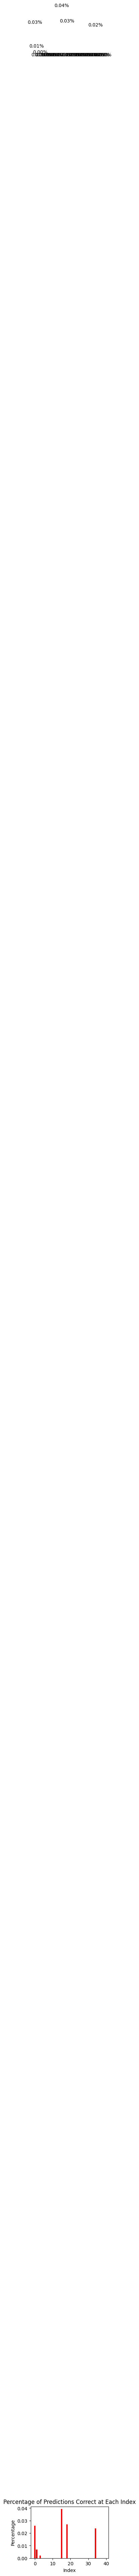

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
labels = array_sum
predictions = array_correct

# Calculate the percentage of correct predictions for each index
percentages = []
for i in range(len(labels)):
    percentage = predictions[i] * 1.0 / labels[i]
    percentages.append(percentage)

print(percentages)

# Create a bar chart for each index
fig, ax = plt.subplots(figsize=(3, 2))
# fig, ax = plt.subplots()
ax.bar(range(len(labels)), percentages, color=['green' if p == 100 else 'red' for p in percentages])
ax.set_xlabel('Index')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Predictions Correct at Each Index')

# Display the percentage on top of the bars
for i, v in enumerate(percentages):
    ax.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', color='black')
plt.show()
